For demo, see the throw.ipynb

Autoformer

In [25]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [26]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, df, context_length, prediction_length, lags_sequence):
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.lags_sequence = lags_sequence
        self.max_lag = max(lags_sequence)
        self.required_past_length = context_length + self.max_lag

        self.values = df['requests'].values
        self.features = df[['memory', 'cpu']].values

        self.length = len(df) - self.required_past_length - prediction_length + 1

        self.static_real = np.array([df['cpu'].mean(), df['memory'].mean()])
        self.static_cat = np.array([0])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        past_values = self.values[idx : idx + self.required_past_length]
        past_time_features = self.features[idx : idx + self.required_past_length]

        future_values = self.values[
            idx + self.required_past_length : idx + self.required_past_length + self.prediction_length
        ]
        future_time_features = self.features[
            idx + self.required_past_length : idx + self.required_past_length + self.prediction_length
        ]

        past_observed_mask = ~np.isnan(past_values)
        future_observed_mask = ~np.isnan(future_values)

        return {
            'past_values': torch.tensor(past_values, dtype=torch.float),
            'past_time_features': torch.tensor(past_time_features, dtype=torch.float),
            'past_observed_mask': torch.tensor(past_observed_mask, dtype=torch.float),
            'future_values': torch.tensor(future_values, dtype=torch.float),
            'future_time_features': torch.tensor(future_time_features, dtype=torch.float),
            'future_observed_mask': torch.tensor(future_observed_mask, dtype=torch.float),
            'static_real_features': torch.tensor(self.static_real, dtype=torch.float),
            'static_categorical_features': torch.tensor(self.static_cat, dtype=torch.long),
        }


In [27]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

In [28]:
lags_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # can include 0 if needed
context_len = 10  # 21 - max(lags_seq)
prediction_len = 1


In [29]:
dataset = TimeSeriesWindowDataset(df, context_length=context_len, prediction_length=prediction_len, lags_sequence=lags_seq)

In [30]:
loader = DataLoader(dataset, batch_size=10, shuffle=True)
for batch in loader:
    print("past values:", batch['past_values'].shape, end="\n")  
    print("past_time_features: ",batch['past_time_features'].shape, end="\n") 
    print("past_observed_mask: ",batch['past_observed_mask'].shape, end="\n")
    print("future_values: ",batch['future_values'].shape, end="\n") 
    print("future_time_series: ",batch['future_time_features'].shape, end="\n") 
    print("future_observed_mask: ",batch['future_observed_mask'].shape, end="\n") 
    break


past values: torch.Size([10, 21])
past_time_features:  torch.Size([10, 21, 2])
past_observed_mask:  torch.Size([10, 21])
future_values:  torch.Size([10, 1])
future_time_series:  torch.Size([10, 1, 2])
future_observed_mask:  torch.Size([10, 1])


MODEL CONFIGURATION

In [31]:
from transformers import AutoformerForPrediction, AutoformerConfig
config = AutoformerConfig(
    context_length=context_len,
    prediction_length=prediction_len,
    lags_sequence=lags_seq,
    input_size=1,
    num_time_features=2,
    static_categorical_cardinalities=[1],
    static_real_features=2
)

# 6. Initialize model
model = AutoformerForPrediction(config)

In [32]:
# 7. Move model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [33]:
# 8. Training Loop — 🔥 INSERT THIS RIGHT HERE!
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 15  #

In [34]:
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        # Move batch tensors to the same device as model
        batch = {k: v.to(device) for k, v in batch.items()}

        output = model(
            past_values=batch['past_values'],
            past_time_features=batch['past_time_features'],
            past_observed_mask=batch['past_observed_mask'],
            future_values=batch['future_values'],
            future_time_features=batch['future_time_features'],
            # static_real_features=batch['static_real_features'],
            # static_categorical_features=batch['static_categorical_features']
        )

        loss = output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 1/15, Loss: 929183560.9255
Epoch 2/15, Loss: 224345793.2792
Epoch 3/15, Loss: 15719164.1974
Epoch 4/15, Loss: 579.7502
Epoch 5/15, Loss: 579.3885
Epoch 6/15, Loss: 572.6250
Epoch 7/15, Loss: 571.9663
Epoch 8/15, Loss: 570.7133
Epoch 9/15, Loss: 569.8002
Epoch 10/15, Loss: 569.1893
Epoch 11/15, Loss: 567.7268
Epoch 12/15, Loss: 567.5966
Epoch 13/15, Loss: 568.5857
Epoch 14/15, Loss: 565.2413
Epoch 15/15, Loss: 563.6271


In [35]:
model.eval()

# Grab a batch
for batch in loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    break

# Generate predictions
with torch.no_grad():
    outputs = model.generate(
        past_values=batch['past_values'],
        past_time_features=batch['past_time_features'],
        past_observed_mask=batch['past_observed_mask'],
        future_time_features=batch['future_time_features'],
        # static_real_features=batch['static_real_features'],  # if you're using these
        # static_categorical_features=batch['static_categorical_features'],
    )

# This is your prediction in normalized form
normalized_forecast = outputs.sequences  # shape: [batch_size, prediction_length, 1]

# 👇 Estimate loc & scale from the actual past input (same as used by model internally)
loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)   # [B, 1, 1]
scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)  # [B, 1, 1]

# Avoid divide-by-zero just in case
scale[scale == 0] = 1.0

# Decode
rescaled_forecast = normalized_forecast * scale + loc

# Get first prediction step
first_pred = rescaled_forecast[:, 0, :]  # [batch_size, 1]
true_values = batch['future_values']

# Display
print("Ground truth:\n", true_values.cpu())
print("First-step Prediction:\n", first_pred.cpu())


Ground truth:
 tensor([[ 6.],
        [17.],
        [13.],
        [ 4.],
        [ 8.],
        [ 2.],
        [10.],
        [ 4.],
        [ 6.],
        [15.]])
First-step Prediction:
 tensor([[8.0408e+01],
        [1.2299e+02],
        [1.4343e+02],
        [7.3188e+00],
        [1.2198e+02],
        [9.8602e-02],
        [3.5550e+01],
        [2.8793e+01],
        [3.1544e+01],
        [3.1790e+01]])


In [36]:
first_pred = rescaled_forecast[:, 0, :]  # shape: [batch_size, 1]
true_values = batch['future_values']     # shape: [batch_size, 1]


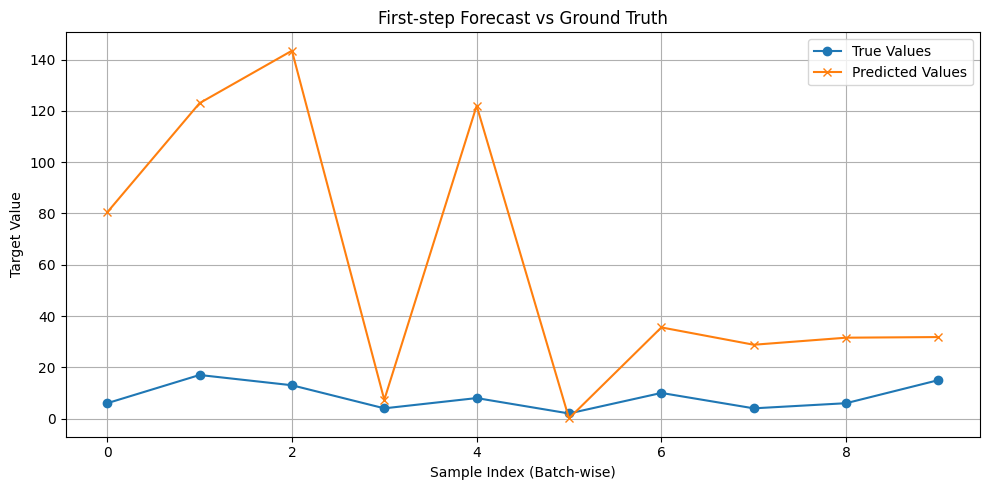

In [37]:
import matplotlib.pyplot as plt

# Convert to numpy for plotting
y_true = true_values.cpu().numpy().flatten()
y_pred = first_pred.cpu().numpy().flatten()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="True Values", marker='o')
plt.plot(y_pred, label="Predicted Values", marker='x')
plt.title("First-step Forecast vs Ground Truth")
plt.xlabel("Sample Index (Batch-wise)")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### INITIAL MODEL CONFIGURATION

In [95]:
output = model.forward(
    past_values=batch['past_values'],
    past_time_features=batch['past_time_features'],
    past_observed_mask=batch['past_observed_mask'],
    future_values=batch['future_values'],
    future_time_features=batch['future_time_features']
)

In [97]:
loss = output.loss

In [98]:
loss.backward()

In [100]:
outputs = model.generate(
    past_values=batch['past_values'],
    past_time_features=batch['past_time_features'],
    past_observed_mask=batch['past_observed_mask'],
    future_time_features=batch['future_time_features']
)

In [108]:
outputs.sequences

tensor([[[-1.4459e+01],
         [ 9.7373e+00],
         [ 7.9672e+00],
         [-8.5676e-01],
         [-3.7641e+00],
         [-4.3858e+00],
         [ 1.6823e+00],
         [-2.2156e+01],
         [-2.5889e+01],
         [-3.7110e+00],
         [-4.5459e+00],
         [-7.8157e+00],
         [-6.6593e+00],
         [-1.1706e+01],
         [-5.0214e+01],
         [-1.4009e+01],
         [-1.1779e+01],
         [-3.9381e+01],
         [-1.0530e+01],
         [ 2.2217e+01],
         [-3.5357e+01],
         [-1.7383e+00],
         [ 3.1627e+01],
         [ 4.6507e+01],
         [ 1.2574e+01],
         [ 1.2332e+01],
         [ 2.8664e+00],
         [ 3.3385e+00],
         [ 3.8122e+01],
         [-2.8269e+00],
         [ 1.2246e+01],
         [ 1.2081e+01],
         [ 3.0244e+01],
         [-1.1418e-01],
         [-1.8732e+01],
         [-2.8565e+00],
         [ 1.6215e+01],
         [ 2.1414e+01],
         [ 3.2576e+01],
         [ 1.9548e+00],
         [ 2.4913e+01],
         [ 3.874

In [111]:
# Unsqueeze loc and scale for broadcasting
loc = output.loc.unsqueeze(1)      # [10, 1] -> [10, 1, 1]
scale = output.scale.unsqueeze(1)  # [10, 1] -> [10, 1, 1]

# Decode
normalized_forecast = outputs.sequences
rescaled_forecast = normalized_forecast * scale + loc

print("Rescaled forecast shape:", rescaled_forecast.shape)
print("Rescaled forecast:", rescaled_forecast)


Rescaled forecast shape: torch.Size([10, 100, 1])
Rescaled forecast: tensor([[[-2.2845e+02],
         [ 1.5385e+02],
         [ 1.2588e+02],
         [-1.3537e+01],
         [-5.9473e+01],
         [-6.9295e+01],
         [ 2.6581e+01],
         [-3.5007e+02],
         [-4.0904e+02],
         [-5.8634e+01],
         [-7.1826e+01],
         [-1.2349e+02],
         [-1.0522e+02],
         [-1.8495e+02],
         [-7.9338e+02],
         [-2.2135e+02],
         [-1.8611e+02],
         [-6.2221e+02],
         [-1.6638e+02],
         [ 3.5102e+02],
         [-5.5864e+02],
         [-2.7465e+01],
         [ 4.9970e+02],
         [ 7.3481e+02],
         [ 1.9867e+02],
         [ 1.9485e+02],
         [ 4.5289e+01],
         [ 5.2749e+01],
         [ 6.0232e+02],
         [-4.4665e+01],
         [ 1.9349e+02],
         [ 1.9089e+02],
         [ 4.7786e+02],
         [-1.8040e+00],
         [-2.9596e+02],
         [-4.5133e+01],
         [ 2.5620e+02],
         [ 3.3834e+02],
         [ 5.1470e+

In [110]:
outputs.sequences.shape

torch.Size([10, 100, 1])

In [112]:
true_values = batch['future_values']
print("Ground truth:", true_values)
print("Prediction:", rescaled_forecast)


Ground truth: tensor([[10.],
        [ 2.],
        [20.],
        [ 8.],
        [ 4.],
        [12.],
        [ 9.],
        [ 0.],
        [10.],
        [ 6.]])
Prediction: tensor([[[-2.2845e+02],
         [ 1.5385e+02],
         [ 1.2588e+02],
         [-1.3537e+01],
         [-5.9473e+01],
         [-6.9295e+01],
         [ 2.6581e+01],
         [-3.5007e+02],
         [-4.0904e+02],
         [-5.8634e+01],
         [-7.1826e+01],
         [-1.2349e+02],
         [-1.0522e+02],
         [-1.8495e+02],
         [-7.9338e+02],
         [-2.2135e+02],
         [-1.8611e+02],
         [-6.2221e+02],
         [-1.6638e+02],
         [ 3.5102e+02],
         [-5.5864e+02],
         [-2.7465e+01],
         [ 4.9970e+02],
         [ 7.3481e+02],
         [ 1.9867e+02],
         [ 1.9485e+02],
         [ 4.5289e+01],
         [ 5.2749e+01],
         [ 6.0232e+02],
         [-4.4665e+01],
         [ 1.9349e+02],
         [ 1.9089e+02],
         [ 4.7786e+02],
         [-1.8040e+00],
       

In [114]:
first_pred = rescaled_forecast[:, 0, :]  # shape: [10, 1]
true_values = batch['future_values']  # shape: [10, 1]
print("Ground truth:", true_values)
print("Prediction:", first_pred)

Ground truth: tensor([[10.],
        [ 2.],
        [20.],
        [ 8.],
        [ 4.],
        [12.],
        [ 9.],
        [ 0.],
        [10.],
        [ 6.]])
Prediction: tensor([[-2.2845e+02],
        [-4.0082e+00],
        [-4.4678e+01],
        [ 7.0444e+00],
        [-1.9773e+00],
        [ 2.6008e+02],
        [-2.1552e+02],
        [-4.3104e-12],
        [-2.1560e+01],
        [ 1.9807e+01]])
